In [83]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-24 20:40:06--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1,36M  --.-KB/s    in 0,1s    

2023-09-24 20:40:07 (9,11 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [84]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

<Axes: >

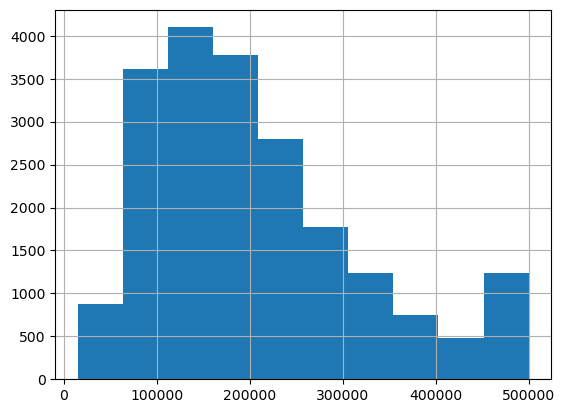

In [85]:
# EDA
housing = pd.read_csv('housing.csv')
housing.median_house_value.hist()

#### Preparing the dataset

For this homework, we only want to use a subset of data.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Next, use only the following columns:

    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'


In [86]:
ocean_proximity_labels  =set(['<1H OCEAN', 'INLAND'])
columns_to_use = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']
housing_reduced = housing[housing.ocean_proximity.isin(ocean_proximity_labels)][columns_to_use]
housing_reduced.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


### Question 1
There's one feature with missing values. What is it?

In [87]:
housing_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            15687 non-null  float64
 1   longitude           15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [88]:
print(f'This column is {housing_reduced.columns[housing_reduced.isna().sum() !=0][0]}')

This column is total_bedrooms


### Question 2
What's the median (50% percentile) for variable 'population'?

In [89]:
print(f'Median for population variable is {housing_reduced.population.median()}')

Median for population variable is 1195.0


### Prepare and split the dataset

    * Shuffle the dataset (the filtered one you created above), use seed 42.
    * Split your data in train/val/test sets, with 60%/20%/20% distribution.
    * Apply the log transformation to the median_house_value variable using the np.log1p() function.


In [90]:
# Shuffling and splitting
n = len(housing_reduced)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

housing_reduced_train = housing_reduced.iloc[idx[:n_train]]
housing_reduced_val = housing_reduced.iloc[idx[n_train:n_train+n_val]]
housing_reduced_test = housing_reduced.iloc[idx[n_train+n_val:]]

In [91]:
housing_reduced_train = housing_reduced_train.reset_index(drop=True)
housing_reduced_val = housing_reduced_val.reset_index(drop=True)
housing_reduced_test = housing_reduced_test.reset_index(drop=True)

In [92]:
y_train = np.log1p(housing_reduced_train['median_house_value'].values)
y_val = np.log1p(housing_reduced_val['median_house_value'].values)
y_test = np.log1p(housing_reduced_test['median_house_value'].values)

In [93]:
del housing_reduced_train['median_house_value']
del housing_reduced_val['median_house_value']
del housing_reduced_test['median_house_value']

### Question 3

    * We need to deal with missing values for the column from Q1.
    * We have two options: fill it with 0 or with the mean of this variable.
    * Try both options. For each, train a linear regression model without regularization using the code from the lessons.
    * For computing the mean, use the training only!
    * Use the validation dataset to evaluate the models and compare the RMSE of each option.
    * Round the RMSE scores to 2 decimal digits using round(score, 2)
    * Which option gives better RMSE?


In [94]:
def fill_na(X, m):
    X_copy = X.copy()
    X_copy.total_bedrooms.fillna(m, inplace=True)
    return X_copy

In [95]:
m = 0
housing_reduced_train_0 = fill_na(housing_reduced_train, 0)
housing_reduced_test_0 = fill_na(housing_reduced_test, 0)
housing_reduced_val_0 = fill_na(housing_reduced_val, 0)

In [96]:
m = housing_reduced_train.total_bedrooms.mean()
housing_reduced_train_mean = fill_na(housing_reduced_train, m)
housing_reduced_test_mean = fill_na(housing_reduced_test, m)
housing_reduced_val_mean = fill_na(housing_reduced_val, m)

In [97]:
def train_and_validate_lin_reg(X_train, y_train, X_val, y_val):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_val_predicted = lr.predict(X_val)
    return round(mean_squared_error(y_val, y_val_predicted, squared=False), 2)

In [98]:
rmse_0 = train_and_validate_lin_reg(housing_reduced_train_0, y_train, housing_reduced_val_0, y_val)

In [99]:
rmse_mean = train_and_validate_lin_reg(housing_reduced_train_mean, y_train, housing_reduced_val_mean, y_val)

In [100]:
rmse_0, rmse_mean

(0.34, 0.34)

There is no difference what filling strategy we use

### Question 4

    * Now let's train a regularized linear regression.
    * For this question, fill the NAs with 0.
    * Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
    * Use RMSE to evaluate the model on the validation dataset.
    * Round the RMSE scores to 2 decimal digits.
    * Which r gives the best RMSE?

If there are multiple options, select the smallest r.

In [101]:
def train_reg_and_return_rmse_on_val(X_train, y_train,X_val,y_val, r):
    print(f'For {r}:')
    ridge = Ridge(alpha=r)
    ridge.fit(X_train, y_train)
    print(round(mean_squared_error(ridge.predict(X_val), y_val,squared=False), 2))
    return round(mean_squared_error(ridge.predict(X_val), y_val,squared=False), 2)

In [102]:
r_arr = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
result_dict = dict.fromkeys(r_arr)
for r in r_arr:
    result_dict[r] = train_reg_and_return_rmse_on_val(housing_reduced_train_0, y_train, housing_reduced_val_0, y_val, r)
    

For 0:
0.34
For 1e-06:
0.34
For 0.0001:
0.34
For 0.001:
0.34
For 0.01:
0.34
For 0.1:
0.34
For 1:
0.34
For 5:
0.34
For 10:
0.34


In [103]:
result_dict

{0: 0.34,
 1e-06: 0.34,
 0.0001: 0.34,
 0.001: 0.34,
 0.01: 0.34,
 0.1: 0.34,
 1: 0.34,
 5: 0.34,
 10: 0.34}

RMSE does not chang, because all the coefficients are small and by using Ridge regression we impose the condition: coefficients are smaller that $1/\alpha$

### Question 5

    We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
    * Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
    * For each seed, do the train/validation/test split with 60%/20%/20% distribution.
    * Fill the missing values with 0 and train a model without regularization.
    * For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    * What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
    * Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

    * 0.5
    * 0.05
    * 0.005
    * 0.0005


In [104]:
def procedure_for_a_seed(seed):
    n = len(housing_reduced)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)

    np.random.seed(seed)
    np.random.shuffle(idx)

    housing_reduced_train = housing_reduced.iloc[idx[:n_train]]
    housing_reduced_val = housing_reduced.iloc[idx[n_train:n_train+n_val]]
    housing_reduced_test = housing_reduced.iloc[idx[n_train+n_val:]]
    
    housing_reduced_train = housing_reduced_train.reset_index(drop=True)
    housing_reduced_val = housing_reduced_val.reset_index(drop=True)
    housing_reduced_test = housing_reduced_test.reset_index(drop=True)
    
    y_train = np.log1p(housing_reduced_train['median_house_value'].values)
    y_val = np.log1p(housing_reduced_val['median_house_value'].values)
    y_test = np.log1p(housing_reduced_test['median_house_value'].values)
    
    del housing_reduced_train['median_house_value']
    del housing_reduced_val['median_house_value']
    del housing_reduced_test['median_house_value']
    
    housing_reduced_train_0 = fill_na(housing_reduced_train, 0)
    housing_reduced_test_0 = fill_na(housing_reduced_test, 0)
    housing_reduced_val_0 = fill_na(housing_reduced_val, 0)
    
    rmse_0 = train_and_validate_lin_reg(housing_reduced_train_0, y_train, housing_reduced_val_0, y_val)
    
    return rmse_0

In [105]:
rmse_scores = [procedure_for_a_seed(seed) for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [106]:
round(np.std(rmse_scores), 3)

0.006

Hence the answer is 0.005

### Question 6

    * Split the dataset like previously, use seed 9.
    * Combine train and validation datasets.
    * Fill the missing values with 0 and train a model with r=0.001.
    * What's the RMSE on the test dataset?


In [107]:
n = len(housing_reduced)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)

np.random.seed(9)
np.random.shuffle(idx)

housing_reduced_train = housing_reduced.iloc[idx[:n_train]]
housing_reduced_val = housing_reduced.iloc[idx[n_train:n_train+n_val]]
housing_reduced_test = housing_reduced.iloc[idx[n_train+n_val:]]
    
housing_reduced_train = housing_reduced_train.reset_index(drop=True)
housing_reduced_val = housing_reduced_val.reset_index(drop=True)
housing_reduced_test = housing_reduced_test.reset_index(drop=True)
    
y_train = np.log1p(housing_reduced_train['median_house_value'].values)
y_val = np.log1p(housing_reduced_val['median_house_value'].values)
y_test = np.log1p(housing_reduced_test['median_house_value'].values)
    
del housing_reduced_train['median_house_value']
del housing_reduced_val['median_house_value']
del housing_reduced_test['median_house_value']
    
housing_reduced_train_0 = fill_na(housing_reduced_train, 0)
housing_reduced_test_0 = fill_na(housing_reduced_test, 0)
housing_reduced_val_0 = fill_na(housing_reduced_val, 0)
    
housing_reduced_train_val_0 = pd.concat([housing_reduced_train_0, housing_reduced_val_0])
y_train_val = np.hstack([y_train, y_val])
    
rmse_0 = train_reg_and_return_rmse_on_val(housing_reduced_train_val_0, y_train_val, housing_reduced_test_0, y_test, r=0.001)

For 0.001:
0.33
